In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
COMPANY = 'kty'

In [3]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [4]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [5]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('kty_m.csv')

In [6]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [7]:
peo_roll_beta

array([0.80625091, 0.81067244, 0.80299828, 0.63664413, 0.56050392,
       0.53869979, 0.53016412, 0.45211186, 0.45260016, 0.50737596,
       0.4998429 , 0.5056064 , 0.49295374, 0.49713233, 0.5331422 ,
       0.49529275, 0.51436861, 0.47931093, 0.56544062, 0.57783644,
       0.74720669, 0.77128431, 0.71903384, 0.68754837, 0.69207273,
       0.69573441, 0.63677636, 0.63833424, 0.62086584, 0.88158112,
       0.82493464, 0.80760956, 0.77960552, 0.72277334, 0.68842068,
       0.71240151, 0.71708076, 0.73199263, 0.66365413, 0.72667784,
       0.73303751, 0.72361171, 0.73956006, 0.74128739, 0.75330037,
       0.74179162, 0.72137181, 0.72234217, 0.71980949, 0.71201699,
       0.72586853, 0.73610085, 0.7304787 , 0.76116016, 0.73387831,
       0.74190745, 0.66151104, 0.65951457, 0.65961885, 0.65585775,
       0.65289511, 0.63271721, 0.68771558, 0.68573773, 0.74225908,
       0.46409134, 0.62614956, 0.60348813, 0.62032857, 0.67390451,
       0.71991995, 0.68543474, 0.66887319, 0.60960344, 0.63152

In [8]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [9]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,0.538700,0.560504,0.636644,0.802998,0.810672,0.806251
6,0.530164,0.538700,0.560504,0.636644,0.802998,0.810672
7,0.452112,0.530164,0.538700,0.560504,0.636644,0.802998
8,0.452600,0.452112,0.530164,0.538700,0.560504,0.636644
9,0.507376,0.452600,0.452112,0.530164,0.538700,0.560504
...,...,...,...,...,...,...
200,0.582292,0.564808,0.603570,0.545815,0.589021,0.535129
201,0.630202,0.582292,0.564808,0.603570,0.545815,0.589021
202,0.566331,0.630202,0.582292,0.564808,0.603570,0.545815
203,0.532220,0.566331,0.630202,0.582292,0.564808,0.603570


In [10]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.560504,0.636644,0.802998,0.810672,0.806251
6,0.538700,0.560504,0.636644,0.802998,0.810672
7,0.530164,0.538700,0.560504,0.636644,0.802998
8,0.452112,0.530164,0.538700,0.560504,0.636644
9,0.452600,0.452112,0.530164,0.538700,0.560504
...,...,...,...,...,...
200,0.564808,0.603570,0.545815,0.589021,0.535129
201,0.582292,0.564808,0.603570,0.545815,0.589021
202,0.630202,0.582292,0.564808,0.603570,0.545815
203,0.566331,0.630202,0.582292,0.564808,0.603570


In [11]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.806251,0.810672,0.802998,0.636644,0.560504
6,0.810672,0.802998,0.636644,0.560504,0.538700
7,0.802998,0.636644,0.560504,0.538700,0.530164
8,0.636644,0.560504,0.538700,0.530164,0.452112
9,0.560504,0.538700,0.530164,0.452112,0.452600
...,...,...,...,...,...
200,0.535129,0.589021,0.545815,0.603570,0.564808
201,0.589021,0.545815,0.603570,0.564808,0.582292
202,0.545815,0.603570,0.564808,0.582292,0.630202
203,0.603570,0.564808,0.582292,0.630202,0.566331


In [12]:
y = df_data.target
y

5      0.538700
6      0.530164
7      0.452112
8      0.452600
9      0.507376
         ...   
200    0.582292
201    0.630202
202    0.566331
203    0.532220
204    0.553655
Name: target, Length: 200, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

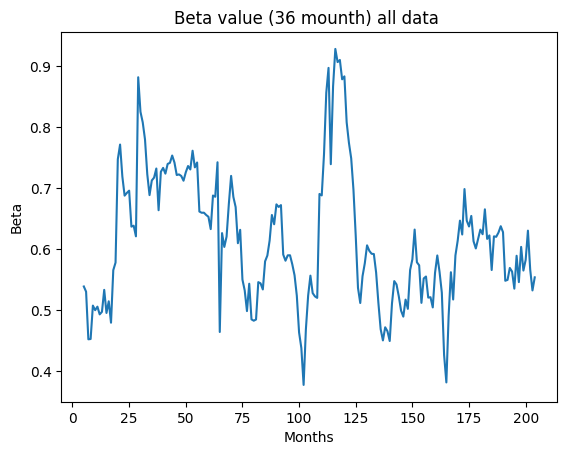

In [14]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [15]:
y_test

165    0.381420
166    0.490166
167    0.562042
168    0.517334
169    0.589598
170    0.613790
171    0.646588
172    0.623876
173    0.698368
174    0.646580
175    0.636993
176    0.654284
177    0.612769
178    0.601012
179    0.616505
180    0.631893
181    0.624308
182    0.665132
183    0.616661
184    0.622389
185    0.565650
186    0.620846
187    0.620103
188    0.627033
189    0.637455
190    0.627679
191    0.548081
192    0.549442
193    0.569042
194    0.563125
195    0.535129
196    0.589021
197    0.545815
198    0.603570
199    0.564808
200    0.582292
201    0.630202
202    0.566331
203    0.532220
204    0.553655
Name: target, dtype: float64

In [16]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [17]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [18]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 3ms/step - loss: 3.1198
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 2.2507
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 1.6333
Epoch 4/200
16/16 [==============================] - 0s 3ms/step - loss: 1.1420
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.7514
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4573
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2533
Epoch 8/200
16/16 [==============================] - 0s 3ms/step - loss: 0.1253
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0604
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0288
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 3ms/step


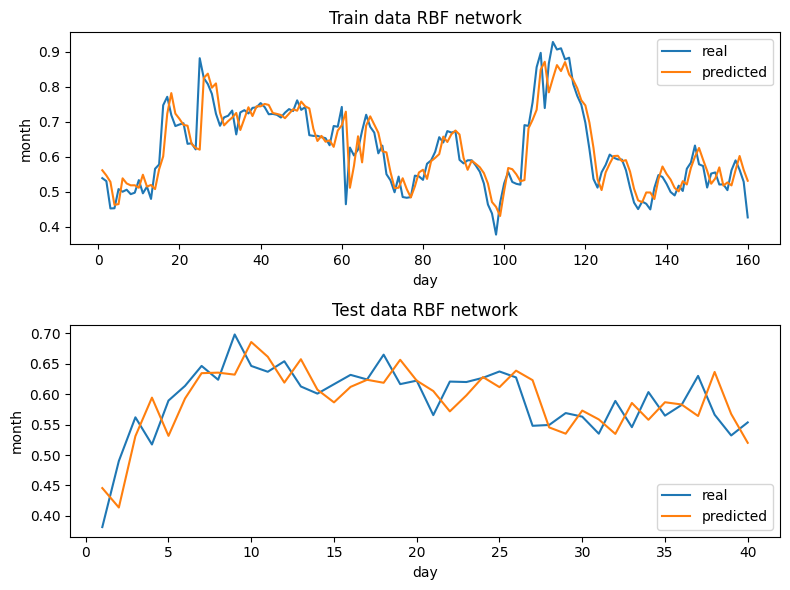

In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [20]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

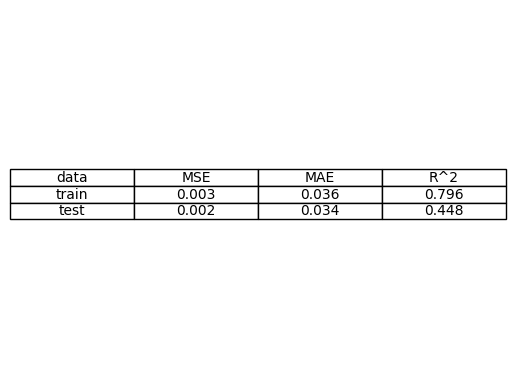

In [21]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [22]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

2/2 [==============================] - 0s 2ms/step


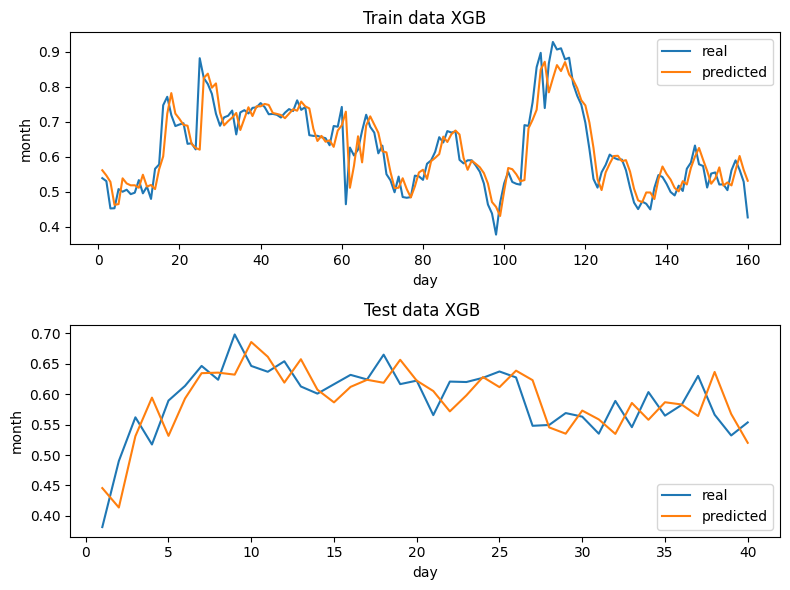

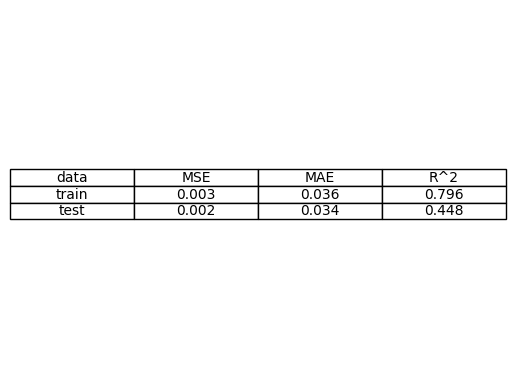

In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 5ms/step - loss: 0.0212
Epoch 2/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0113
Epoch 3/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0103
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0097
Epoch 5/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0092
Epoch 6/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0100
Epoch 7/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0094
Epoch 8/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0076
Epoch 9/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0071
Epoch 10/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 11/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0074
Epoch 12/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0063
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 0s/step


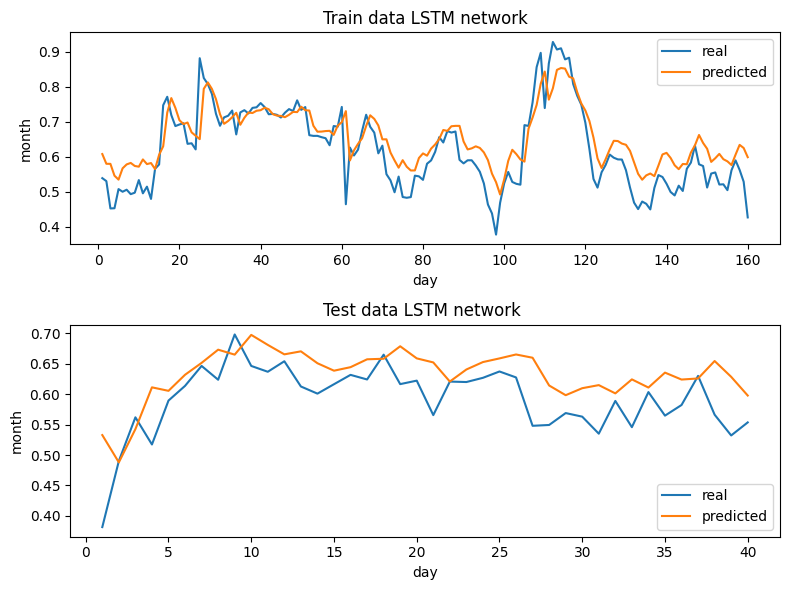

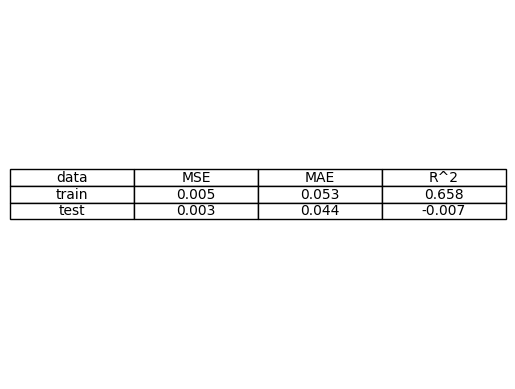

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

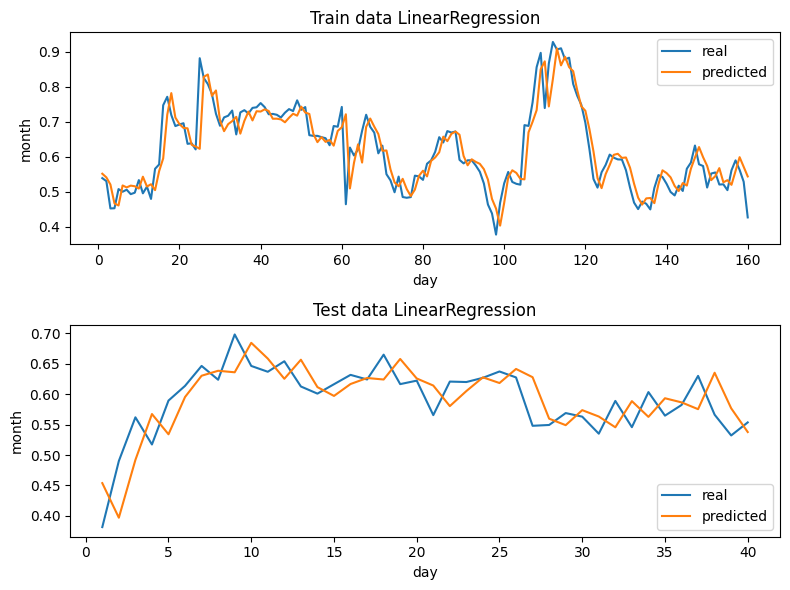

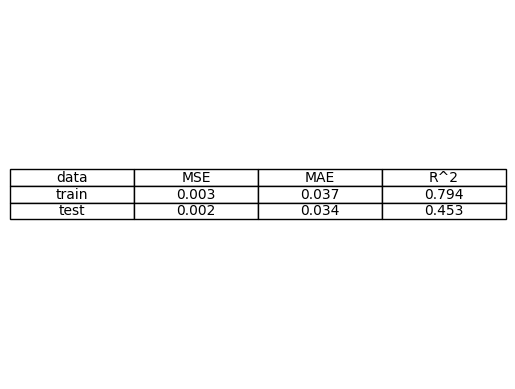

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')